In [1]:
# --- CELL 1: SETUP ---

# 1. FIX: Downgrade protobuf to prevent 'GetPrototype' error
# We run this first and separately to ensure it locks the version
!pip install -q protobuf==3.20.3

# 2. Install the rest of the libraries
!pip install -q diffusers transformers accelerate controlnet_aux safetensors ultralytics sahi openvino-dev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

In [2]:
# --- CELL 1: IMPORTS & CONFIG ---
import os
import gc
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

# USER CONFIGURATION
INPUT_PATH_PATTERN = "/kaggle/input/dataset/Dataset/images/*" 
INPUT_LABELS_DIR = "/kaggle/input/dataset/Dataset/labels"
DEMO_LIMIT = 20         
OUTPUT_DIR = "/kaggle/working/demo_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hardware Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Hardware Check: {DEVICE} is active.")

# HELPER FUNCTIONS
def get_image_files(pattern):
    files = glob.glob(pattern)
    return sorted([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

def read_yolo_labels(txt_path, width, height):
    boxes = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    c, x, y, w, h = map(float, parts)
                    if int(c) == 0: boxes.append([x, y, w, h])
    return boxes

def create_mask(image, boxes):
    w, h = image.size
    mask = Image.new("L", (w, h), 255) 
    draw = ImageDraw.Draw(mask)
    for (xc, yc, bw, bh) in boxes:
        x1, y1, x2, y2 = int((xc-bw/2)*w), int((yc-bh/2)*h), int((xc+bw/2)*w), int((yc+bh/2)*h)
        draw.rectangle([x1, y1, x2, y2], fill=0)
    return mask

def visualize_sample(original, mask, generated, filename):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Mask"); plt.imshow(mask, cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("Result"); plt.imshow(generated); plt.axis('off')
    plt.show()

2026-01-15 10:47:25.156635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768474045.350803      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768474045.409181      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Hardware Check: cuda is active.


Starting STRUCTURED FIRE run on 20 images...


config.json:   0%|          | 0.00/945 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Processing:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

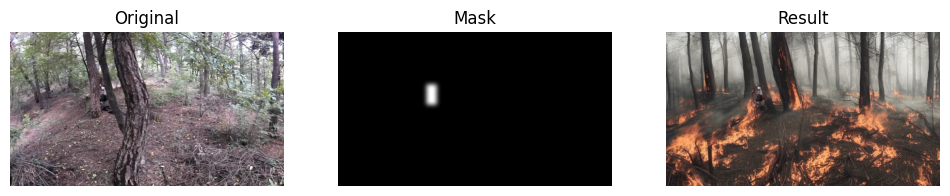

  0%|          | 0/42 [00:00<?, ?it/s]

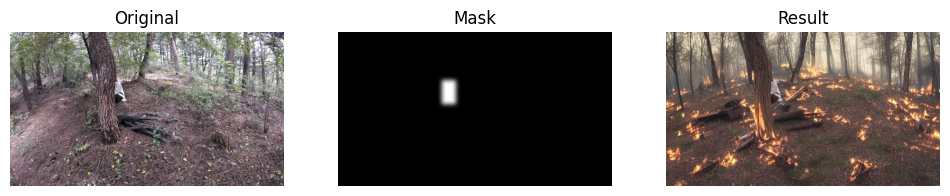

  0%|          | 0/42 [00:00<?, ?it/s]

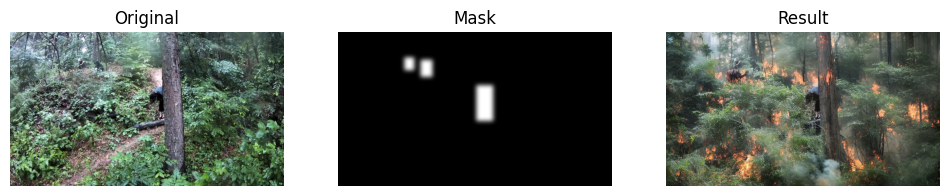

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Stage 1 Done. Structure preserved, massive fire applied.


In [3]:
# --- CELL 2: FINAL FIX - STRUCTURED MASSIVE FIRE & TRAPPED PERSON ---
import random
import numpy as np
from PIL import Image, ImageOps, ImageFilter, ImageEnhance

# 1. SETUP
image_files = get_image_files(INPUT_PATH_PATTERN)
if not image_files:
    print("ERROR: No images found.")
else:
    demo_files = image_files[:DEMO_LIMIT]
    print(f"Starting STRUCTURED FIRE run on {len(demo_files)} images...")

    # Load Models
    cn = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16)
    pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        controlnet=cn,
        torch_dtype=torch.float16,
        safety_checker=None
    )
    pipe.enable_model_cpu_offload()
    pipe.enable_vae_slicing()
    
    generated_data = [] 

    # PROMPTS: Focused on "Fire ON trees" rather than "Fire instead of trees"
    PROMPTS = [
        "massive forest fire, flames climbing up the original tree trunks, burning branches, forest floor covered in fire and embers, thick smoke, intense heat, realistic texture, cinematic lighting, 8k",
        "raging wildfire inside a forest, trees are burning but standing, ground vegetation on fire, heavy smoke, orange glow, dramatic shadows, photorealistic",
        "apocalyptic fire in the woods, burning bark, bright flames surrounding the area, dark ash ground, volumetric lighting from the fire"
    ]

    # Negative prompt to prevent changing the scene type
    NEGATIVE_PROMPT = "lava lake, volcano, magma ground, aerial view, destroyed landscape, flat ground, cartoon, blurry, melting objects, disappearing trees"

    for img_path in tqdm(demo_files, desc="Processing"):
        try:
            filename = os.path.basename(img_path)
            
            # Load & Resize
            img = Image.open(img_path).convert("RGB")
            img.thumbnail((1024, 1024), Image.Resampling.LANCZOS)
            W, H = img.size
            
            # Get Labels
            label_name = os.path.splitext(filename)[0] + ".txt"
            label_candidates = glob.glob(os.path.join(INPUT_LABELS_DIR, "**", label_name), recursive=True)
            label_path = label_candidates[0] if label_candidates else None
            
            boxes = []
            if label_path:
                boxes = read_yolo_labels(label_path, W, H)
            
            # Masking
            mask = create_mask(img, boxes)
            
            # Generate
            chosen_prompt = random.choice(PROMPTS)
            generator = torch.Generator(device="cpu").manual_seed(random.randint(0, 9999))
            
            out = pipe(
                prompt=chosen_prompt,
                negative_prompt=NEGATIVE_PROMPT,
                image=img,
                mask_image=mask,
                control_image=img,
                num_inference_steps=50, # High steps for detail
                
                # === THE CRITICAL FIXES ===
                strength=0.85,                      # Enough to burn green->orange, but keeps textures
                controlnet_conditioning_scale=0.80, # VERY HIGH: Forces model to keep original tree shapes!
                guidance_scale=10.0,                # Strong adherence to "Fire" prompt
                generator=generator
            ).images[0]
            
            # === ADVANCED LIGHTING INTEGRATION (The "Trapped" Look) ===
            
            # 1. Prepare Organic Mask for the person
            person_mask_raw = ImageOps.invert(mask)
            # Soft blur to blend edges
            organic_mask = person_mask_raw.filter(ImageFilter.GaussianBlur(radius=8))
            
            # 2. Create "Fire Ambiance Map"
            # We blur the generated fire image heavily to get the light color
            fire_light_map = out.filter(ImageFilter.GaussianBlur(radius=40))
            
            # 3. Tint the Person (Stronger blend for "Trapped" feel)
            # Blend original person with the fire light map (40% fire light)
            tinted_person = Image.blend(img, fire_light_map, alpha=0.40)
            
            # 4. Add Contrast (Fire creates harsh shadows)
            enhancer = ImageEnhance.Contrast(tinted_person)
            tinted_person = enhancer.enhance(1.15) # Boost contrast by 15%
            
            # 5. Composite Person onto Fire Background
            scene_with_person = Image.composite(tinted_person, out, organic_mask)
            
            # 6. Global Smoke Overlay (To make them really look "inside")
            # We mix 10% of the raw fire/smoke image over the person layer too
            # This simulates smoke passing *in front* of the person
            final_image = Image.blend(scene_with_person, out, alpha=0.10)

            # Save
            out_name = f"massive_{filename}"
            save_path = os.path.join(OUTPUT_DIR, out_name)
            final_image.save(save_path)
            generated_data.append(save_path)
            
            # Visual Check
            if len(generated_data) <= 3:
                visualize_sample(img, organic_mask, final_image, filename)
                
            torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # CLEANUP
    del pipe, cn
    gc.collect()
    torch.cuda.empty_cache()
    print("Stage 1 Done. Structure preserved, massive fire applied.")

In [4]:
# # --- CELL 2: STRUCTURAL FIRE INJECTION ---
# import random

# # 1. SETUP
# image_files = get_image_files(INPUT_PATH_PATTERN)

# if not image_files:
#     print("❌ ERROR: No images found.")
# else:
#     demo_files = image_files[:DEMO_LIMIT]
#     print(f"🚀 Starting STRUCTURAL FIRE run on {len(demo_files)} images...")

#     # Load Models
#     cn = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16)
#     pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
#         "runwayml/stable-diffusion-inpainting",
#         controlnet=cn,
#         torch_dtype=torch.float16,
#         safety_checker=None
#     )
#     pipe.enable_model_cpu_offload() 
#     pipe.enable_vae_slicing()
    
#     generated_data = [] 

#     # PROMPTS: Focused on "Texture" change (burning, charred, smoke)
#     PROMPTS = [
#         "forest fire, burning tree trunks, charred wood, glowing embers on the ground, heavy smoke, realistic texture, 8k",
#         "trees on fire, orange flames consuming leaves, thick gray smoke, heat haze, cinematic lighting, photorealistic",
#         "smoldering forest, burnt ground, black soot, small flames on tree bark, intense smoke"
#     ]

#     for img_path in tqdm(demo_files, desc="Burning Trees"):
#         try:
#             filename = os.path.basename(img_path)
            
#             # Load & Resize
#             img = Image.open(img_path).convert("RGB")
#             img.thumbnail((1024, 1024), Image.Resampling.LANCZOS)
#             W, H = img.size
            
#             # Get Labels
#             label_name = os.path.splitext(filename)[0] + ".txt"
#             label_candidates = glob.glob(os.path.join(INPUT_LABELS_DIR, "**", label_name), recursive=True)
#             label_path = label_candidates[0] if label_candidates else None
            
#             boxes = []
#             if label_path:
#                 boxes = read_yolo_labels(label_path, W, H)
            
#             # MASKING: Only protect the PERSON. Let the forest burn.
#             mask = create_mask(img, boxes)
            
#             # Generate
#             chosen_prompt = random.choice(PROMPTS)
#             generator = torch.Generator(device="cpu").manual_seed(random.randint(0, 9999))
            
#             out = pipe(
#                 prompt=chosen_prompt,
#                 negative_prompt="new trees, new plants, extra trees, changing geometry, cartoon, painting, blurry, low quality",
#                 image=img,
#                 mask_image=mask,
#                 control_image=img,     # Force it to look at original depth
#                 num_inference_steps=30,
                
#                 # === THE MAGIC SETTINGS ===
#                 strength=0.75,         # < 0.8 means "Don't invent new objects, just re-texture"
#                 controlnet_conditioning_scale=1.0, # 1.0 means "STRICTLY follow the original 3D shape"
#                 guidance_scale=8.0,
#                 generator=generator
#             ).images[0]
            
#             # Save
#             out_name = f"fire_{filename}"
#             save_path = os.path.join(OUTPUT_DIR, out_name)
#             out.save(save_path)
#             generated_data.append(save_path)
            
#             # Visual Check
#             if len(generated_data) <= 3:
#                 visualize_sample(img, mask, out, filename)
                
#             torch.cuda.empty_cache()
                
#         except Exception as e:
#             print(f"⚠️ Error processing {filename}: {e}")

#     # CLEANUP
#     del pipe, cn
#     gc.collect()
#     torch.cuda.empty_cache()
#     print("✅ Stage 1 Done. Forest is burning (structurally intact).")

In [5]:
 
    # --- STAGE 2: AUTO-LABELING (The Labeler) ---
    print("\n[Stage 2/2] Loading Grounding DINO...")
    
    processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
    model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").to(DEVICE)
    
    print("Labeling generated images...")
    for gen_path in tqdm(generated_data, desc="Tagging"):
        image_pil = Image.open(gen_path).convert("RGB")
        
        # Detect Fire & Smoke
        inputs = processor(images=image_pil, text=["fire", "smoke"], return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = model(**inputs)
            
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.35,
            text_threshold=0.25,
            target_sizes=[image_pil.size[::-1]]
        )[0]
        
        # --- MERGING LABELS ---
        # 1. Recover Original People Boxes
        original_fname = os.path.basename(gen_path).replace("fire_", "")
        original_label_name = os.path.splitext(original_fname)[0] + ".txt"
        
        label_candidates = glob.glob(os.path.join(INPUT_LABELS_DIR, "**", original_label_name), recursive=True)
        orig_label_path = label_candidates[0] if label_candidates else None
        
        final_lines = []
        
        # Add old people labels (Class 0)
        if orig_label_path:
             with open(orig_label_path, 'r') as f:
                for line in f:
                    # Keep existing people
                    if line.strip().startswith("0"): 
                        final_lines.append(line.strip())

        # Add new Fire (Class 1) and Smoke (Class 2) labels
        W, H = image_pil.size
        for label, box in zip(results["labels"], results["boxes"]):
            cls_id = 1 if label == "fire" else 2
            x1, y1, x2, y2 = box.tolist()
            
            # Convert to YOLO format
            xc = ((x1 + x2) / 2) / W
            yc = ((y1 + y2) / 2) / H
            bw = (x2 - x1) / W
            bh = (y2 - y1) / H
            
            final_lines.append(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")
            
        # Save merged txt file
        txt_save_path = gen_path.rsplit('.', 1)[0] + ".txt"
        with open(txt_save_path, 'w') as f:
            f.write("\n".join(final_lines))

    print(f"\n✅ SUCCESS! Processed {len(generated_data)} images.")
    print(f"📁 Check the Output folder: {OUTPUT_DIR}")


[Stage 2/2] Loading Grounding DINO...


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

Labeling generated images...


Tagging:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)



✅ SUCCESS! Processed 20 images.
📁 Check the Output folder: /kaggle/working/demo_output


In [6]:
import shutil
from IPython.display import FileLink

shutil.make_archive('fire_dataset', 'zip', OUTPUT_DIR)

print("ZIP file created successfully!")
FileLink(r'fire_dataset.zip')

ZIP file created successfully!


/kaggle/working/fire_dataset.zip